# RGBChem

RGBChem is a methodology for predicting the properties of chemical compounds by transforming data into RGB images.

This Jupyter Notebook provides an overview of the key concepts underlying the entire workflow and serves as a tutorial on the usage of our code.

## Loading python files from github (Google Colab only)

In [1]:
#choose whether you run the code on colab or locally
colab = True

In [2]:
from git import Repo

repo_url = 'https://github.com/all2gos/RGBChem.git'

if colab:
    repo_path = '/content/RGBChem'
    Repo.clone_from(repo_url, repo_path)
    !mv /content/RGBChem/* .
    !rm -rf /content/RGBChem

## Data Preparation

For the purpose of demonstrating a working implementation, we will utilize the [qm7 database](https://www.nature.com/articles/sdata201422), which comprises 3,993 organic molecules containing up to seven heavy atoms (CONF).

First, it is necessary to select the appropriate parameters for training.

In [1]:
from scripts.utils import modify_params
import scripts.params
import importlib

#to minimize training time, we impose certain constraints by selecting the CYCLE:1 setting, utilizing the qm7_demo database,
#limiting training to 8 epochs, and employing the S2CNN architecture.

changes_dict = {'CYCLE':1,'DB':'qm7_demo','PATH':'/content', 'MODEL':'S2CNN()','EPOCHS':8}

modify_params(changes_dict) #change parameter in scripts/params.py
importlib.reload(scripts.params) #reload file
from scripts.params import *
#after running this cell you have to restart Google Colab, and run this cell again to load params.py correctly into Google Colab memory

Now we are ready to create database.

In [2]:
from scripts.making_df import *
from scripts.params import *

making_df() #takes around 7-8 minutes on cpu

Extracting data from .tar file
Program found 133885 files in data directory
Creating a database of length 133885
Progress: 100.00/100
Reading df
Len of df:133885

Database of lenght 3993 was successfully created based on 133885 files (Shuffle: groups, number of data point per molecule: 1). Name of db: /content/qm7_demo.csv


In [3]:
import pandas as pd

ds = pd.read_csv(f'{PATH}/{DB}.csv')
ds.drop(['atom_type','cords','mulliken'],axis=1).head()

,Unnamed: 0,n_atoms,ID,A,B,C,Dipole moment,Isotropic Polarizability,Energy of HOMO,Energy of LUMO,...,Free energy at 298K,Heat capacity at 298K,Number_of_C,Number_of_O,Number_of_N,Number_of_F,Number_of_H,Sum_of_heavy_atoms,possible_comb,bandgap_correct
0,41,17,gdb_2709_41,16.49141,0.82970,0.80582,2.9650,62.45,-0.2560,-0.0267,...,-346.890211,29.062,5,2,0,0,10,7,870912000.0,-0.0218
1,81,13,gdb_3280_81,5.49452,2.56783,2.07208,1.9615,53.68,-0.2494,-0.0310,...,-344.460450,21.393,5,2,0,0,6,7,172800.0,-0.0327
2,132,15,gdb_2151_132,3.72100,3.03359,1.93442,1.0376,57.79,-0.2527,0.0085,...,-345.688964,25.052,5,2,0,0,8,7,9676800.0,0.0101
3,150,13,gdb_2286_150,9.96411,1.33561,1.25859,2.7620,51.86,-0.2659,-0.0022,...,-381.612912,22.610,4,3,0,0,6,7,103680.0,0.0126
4,189,10,gdb_2120_189,3.86078,3.68965,1.90999,4.5755,45.70,-0.2906,-0.0619,...,-396.516349,19.388,3,3,1,0,3,7,216.0,-0.0224


## Image Creation

The whole procedure is based on the following concepts:

- We represent a molecule with $N$ atoms as a matrix of dimensions $(N+m)\times(N+m)$, where $m$ is some assumed margin that makes all generated images of the same size
- In cells where $i=j$ (i.e., on the diagonal of the matrix), we can put information about properties specific to individual atoms (e.g., atomic charge)
- In all cells we can include information describing the relationship between atom $i$ and $j$. Values for some properties are present in all cells (e.g. Coulomb charge), some are zeroes on diagonal (e.g. Cartesian distance between atoms)
- In this way, we obtain 3 matrices that are direct information about the scale of each color in the RGB system. Based on this we generate the corresponding images.

In this demo we perform creating one image per one molecule. However you can simply increase this value by changing CYCLE parameter in params.py file.


The entire procedure is based on the following concepts:

- A molecule with $N$ atoms is represented as a matrix of dimensions $(N+m)\times(N+m)$, where $m$ is an assumed margin that ensures all generated images are of the same size.
- In the cells where $i=j$ (i.e., along the diagonal of the matrix), information specific to individual atoms can be placed (e.g., atomic charge).
- In all cells, information describing the relationship between atom $i$ and atom $j$ can be included. Certain properties are represented across all cells (e.g., Coulomb charge), while others are zero on the diagonal (e.g., Cartesian distance between atoms).
- This results in three matrices that provide direct information about the scale of each color in the RGB system.

Based on this data, the corresponding images are generated.

In this demonstration, we generate one image per molecule. However, the number of images can be easily increased by modifying the `CYCLE` parameter in the `scripts/params.py` file.


In [4]:
from scripts.dataloaders import dataloader_conv #this function perform .png files creation and DataLoader and Dataset PyTorch object creation

dl = dataloader_conv(200) #you can specify the quantity of generated images

reading files
/content/data
Creating 201 images for training model
Rearranging train and test files
Calibration for each spectra (based on 10.00% of data):
Calibration: 99.95%
r_range= 0.00, 8.00
g_range= 0.00, 41.00
b_range= 0.00, 9.00
Creating images, this process may take a lot of time
Running with multiprocessing using 6 processes
169 goes to test set
Creating images has been finished. There are 173 files in train directory and 15 in test directory.


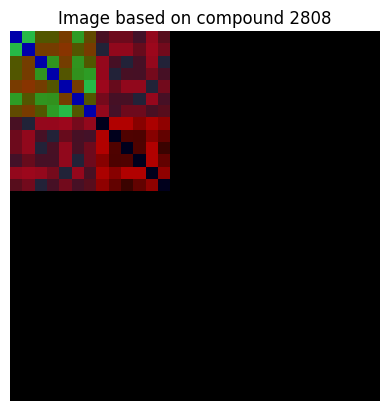

In [5]:
#print example image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

file_path = os.listdir(f'{PATH}/{TEST_DIR_NAME}')[0]
img = mpimg.imread(f"{PATH}/{TEST_DIR_NAME}/{file_path}")

plt.imshow(img)
plt.axis('off')
plt.title(f'Image based on compound {file_path.split("_")[1]}')
plt.show()

## Training the Model

The entire training procedure (including database and image creation) can be performed using a single function from the `run_fastai.py` file. The training process can be manipulated by modifying the corresponding parameters in the `scripts/params.py` file.


In [1]:
from run_fastai import *

training_workflow() #~20 mins on cpu, we recommend utilizing some GPU resources

reading files
Creating 3993 images for training model
Rearranging train and test files
Calibration for each spectra (based on 10.00% of data):
Calibration: 99.80%
r_range= 0.00, 8.00
g_range= 0.00, 41.00
b_range= 0.00, 9.00
Creating images, this process may take a lot of time
Running with multiprocessing using 6 processes
3990 goes to test set
Creating images has been finished. There are 3327 files in train directory and 293 in test directory.
qm7_vanilla.csv have been found in directory

---All params list---
BATCH_SIZE = 60
CYCLE = 1
DB = qm7_demo
DEVICE = cuda
EPOCHS = 8
LEARNING_RATE = 0.00181
LOG_FILE = qm7_demoDS2CNN()_black_e8_bandgap_bs60_size30_shuffle_groups_1.log
MATRIX_SIZE = 30
MOMENTUM = 0.81
PATH = /content
PREDICTED_VALUE = bandgap
SHUFFLE = groups
TEST_DIR_NAME = test
TRAIN_DIR_NAME = train
TRAIN_TEST_SPLIT = 0.9
SCALING = True
DELETE = True
TYPE_OF_IMAGE = D
PATIENCE = 44
DELTA = 0
MODEL = S2CNN()
RANDOM_OR = False
MARGIN = black
RESIZE = 0
STEP = 10
BATTERY_LEVEL_CON

epoch,train_loss,valid_loss,mae,time
0,0.004054,0.002529,0.038068,00:03


Better model found at epoch 0 with valid_loss value: 0.0025285896845161915.


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,mae,time
0,0.002178,0.002336,0.036232,00:03
1,0.002070,0.002225,0.035483,00:04
2,0.001883,0.002020,0.033451,00:02
3,0.001724,0.002010,0.033664,00:02
4,0.001637,0.001919,0.032515,00:02
5,0.001536,0.001891,0.032663,00:04
6,0.001503,0.001873,0.032188,00:03
7,0.001491,0.001872,0.032161,00:02


Better model found at epoch 0 with valid_loss value: 0.002336061093956232.
Better model found at epoch 1 with valid_loss value: 0.0022247950546443462.
Better model found at epoch 2 with valid_loss value: 0.002019924810156226.
Better model found at epoch 3 with valid_loss value: 0.002010301686823368.
Better model found at epoch 4 with valid_loss value: 0.0019193907501176.
Better model found at epoch 5 with valid_loss value: 0.0018905394244939089.
Better model found at epoch 6 with valid_loss value: 0.0018728537252172828.
Better model found at epoch 7 with valid_loss value: 0.0018716179765760899.
File gdb_103_91602.png have been successfully moved to /content
Validation...


99.66
 Average prediction error on test set: 810.55 meV
Creating a log file qm7_demoDS2CNN()_black_e8_bandgap_bs60_size30_shuffle_groups_1.log in /content location


The accuracy of this model is not particularly high. However, generating a larger number of images per molecule, utilizing a more extensive database, and refining the training process can significantly improve the results.